In [22]:
import pandas_datareader.data as web
import datetime
#from pytrends.request import TrendReq
import matplotlib.pyplot as plt
#import requests
import pandas as pd 
#import io
import numpy as np
import statsmodels.api as sm
#from IPython.display import display, Markdown, Latex

In [23]:
figsize = (12,5)
fontsize = 10

## Import google trends data and Michigan data 

In [24]:
## google search 
ue_search = pd.read_excel('../Data/UEGoogle.xls')
ue_search.index = ue_search['Month']

ue_search.index = pd.DatetimeIndex(pd.to_datetime(ue_search.index,
                                                  format = '%Y-%m'),
                                  freq='infer')
ue_search.index.name = None

ue_search = ue_search.rename(columns = 
                             {'unemployment insurance: (United States)':'Search: \"unemployment insurance\"',
                             'unemployment office: (United States)':'Search: \"unemployment office\"',
                             'file for unemployment: (United States)':'Search: \"file for unemployment\"',
                             'unemployment: (United States)':'Search: \"unemployment\"',
                             'unemployed: (United States)':'Search: \"unemployed\"'}
                            )

In [25]:
searches = ['Search: \"unemployment insurance\"',
            'Search: \"unemployment\"',
            'Search: \"unemployed\"',
            'Search: \"unemployment office\"',
            'Search: \"file for unemployment\"'
           ]

##########################################################
sub_searches = searches[0:4]
#########################################################

ue_search = ue_search[sub_searches]

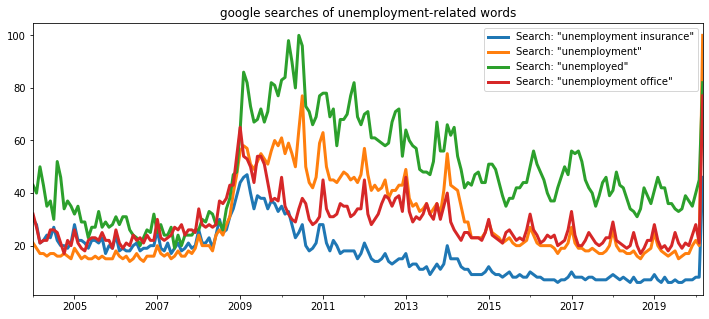

In [26]:
ue_search.plot(lw = 3,
               figsize = figsize,
               title = 'google searches of unemployment-related words')
plt.savefig('figures/working/search')

In [27]:
## normalize each indicies by its initial value. 

for search in sub_searches:
    ue_search[search] = ue_search[search]*100/ue_search[search][0]

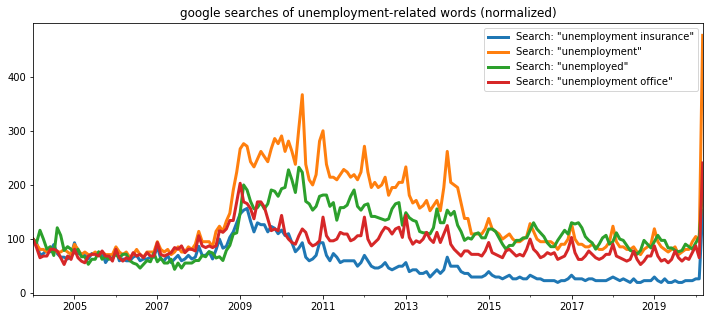

In [28]:
## after normalization
ue_search.plot(lw = 3,
               figsize = figsize,
               title = 'google searches of unemployment-related words (normalized)')
plt.savefig('figures/working/search_normalized')

In [29]:
## michigan data 
ue_exp = pd.read_excel('../Data/UEExpMichigan.xls',
                       sheet_name = 'Data',
                       index_col = 0)

ue_exp = ue_exp.loc[ue_exp.index.dropna(how='all')]

ue_exp.index = pd.DatetimeIndex(pd.to_datetime(ue_exp.index,
                                               format = '%Y-%m-%d'),
                                  freq = 'infer')
ue_exp.index.name = None

The index was not in the monthly frequency in the begining of the sample (between 1960-1978). I undertake a linear interpolation to convert it into a monthly series. 

In [30]:
## linear interpolation 
#ue_exp['UMEX_R'] = ue_exp['UMEX_R'].interpolate()
"""
## plot 
ax = plt.figure(figsize = figsize)
plt.plot(ue_exp['UMEX_R'].index,
         ue_exp['UMEX_R'],
         'b*-',
         lw = 3)
plt.title = 'unemployment expectation index'
plt.savefig('figures/working/ue_exp_idx')
"""

"\n## plot \nax = plt.figure(figsize = figsize)\nplt.plot(ue_exp['UMEX_R'].index,\n         ue_exp['UMEX_R'],\n         'b*-',\n         lw = 3)\nplt.title = 'unemployment expectation index'\nplt.savefig('figures/working/ue_exp_idx')\n"

In [31]:
print(ue_exp.iloc[0:20,:])

            Recession  UMEX_R
1960-01-01        NaN     NaN
1960-02-01        NaN     NaN
1960-03-01        NaN     NaN
1960-04-01        NaN     NaN
1960-05-01     139.74     NaN
1960-06-01     139.74     NaN
1960-07-01     139.74     NaN
1960-08-01     139.74     NaN
1960-09-01     139.74     NaN
1960-10-01     139.74     NaN
1960-11-01     139.74   110.0
1960-12-01     139.74     NaN
1961-01-01     139.74     NaN
1961-02-01     139.74     NaN
1961-03-01        NaN     NaN
1961-04-01        NaN     NaN
1961-05-01        NaN   133.0
1961-06-01        NaN     NaN
1961-07-01        NaN     NaN
1961-08-01        NaN     NaN


## Unemployement rate

In [32]:
start = datetime.datetime(1960, 1, 30)
end = datetime.datetime(2020, 3, 30)
ue = web.DataReader('UNRATE', 'fred', start, end)

In [33]:
ue.index = pd.DatetimeIndex(pd.to_datetime(ue.index,
                                           format = '%Y-%m-%d'),
                                  freq = 'infer')
ue.index.name = None

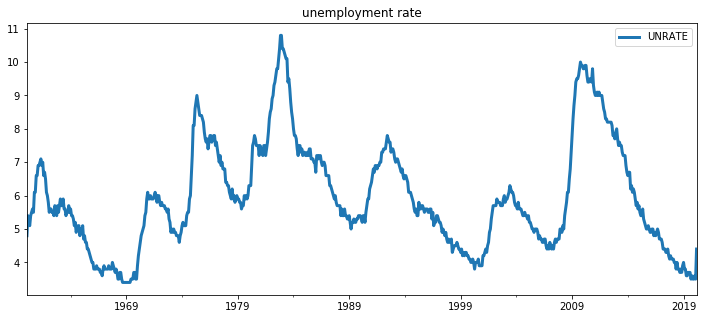

In [34]:
ue.plot(lw = 3,
        figsize = figsize,
        title = 'unemployment rate')
plt.savefig('figures/working/ue')

## Retail series (excluding vehicles and gas) 

In [35]:
## downloading data from fred 

retail = web.DataReader('MARTSSM44W72USS', 'fred', start, end)
pce_idx = web.DataReader('PCEPI', 'fred', start, end)

retail.index = pd.DatetimeIndex(pd.to_datetime(retail.index,
                                               format = '%Y-%m-%d'),
                                freq = 'MS')

retail = retail.rename(columns={'MARTSSM44W72USS':'retail'})

pce_idx.index = pd.DatetimeIndex(pd.to_datetime(pce_idx.index,
                                               format = '%Y-%m-%d'),
                                freq = 'infer')
retail.index.name = None
pce_idx.index.name = None

## converting from nominal to real  

retail_pce = pd.merge(retail,
                      pce_idx,
                      left_index = True,
                      right_index = True)

In [36]:
retail_pce['deflator'] = retail_pce['PCEPI']/retail_pce['PCEPI'][0]
retail_pce['retail_real'] = retail_pce['retail']/retail_pce['deflator']
retail_pce['lretail_real'] = np.log(retail_pce['retail_real'])
retail_pce['retail_yoy'] = retail_pce['lretail_real'].diff(periods = 12)*100
retail = retail_pce['retail_yoy']

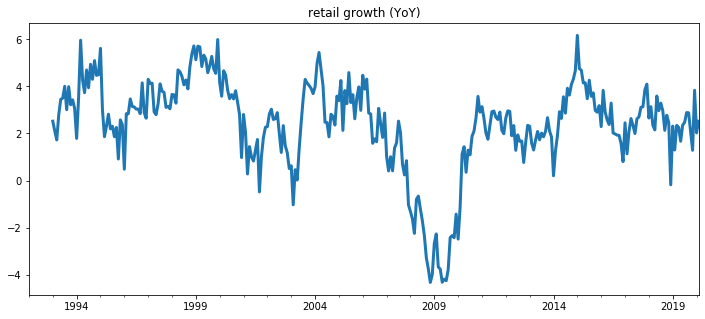

In [37]:
retail.plot(lw = 3,
        figsize = figsize,
        title = 'retail growth (YoY)')
plt.savefig('figures/working/retail')

### UE expectation from SCE

In [38]:
ue_prob = pd.read_excel('../Data/SCE.xls',
                       sheet_name = 'Job separation expectation')
ue_prob.index = ue_prob['Month']

In [39]:
ue_prob.index = pd.DatetimeIndex(pd.to_datetime(ue_prob.index,
                                                format = '%Y%m'),
                                  freq='infer')
ue_prob.index.name = None
ue_prob = ue_prob.drop(columns = ['Month',
                                 'Mean probability of leaving a job voluntarily'])
ue_prob = ue_prob.rename(columns = {'Mean probability of losing a job':'ue_prob'})

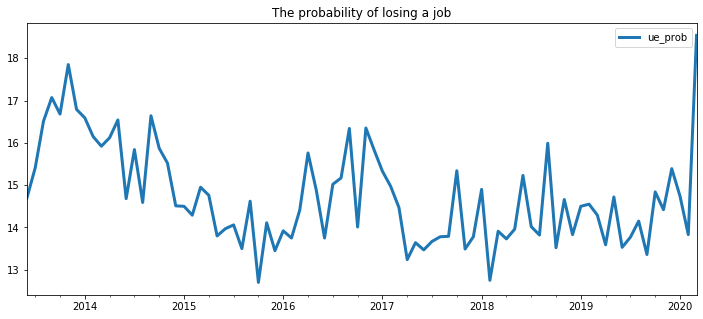

In [40]:
ue_prob.plot(lw = 3,
        figsize = figsize,
        title = 'The probability of losing a job')
plt.savefig('figures/ue_prob')

## Combine all series 

In [41]:
temp = pd.merge(ue_search,
                ue_exp,
                left_index = True,
                right_index = True,
                how = 'outer'
               )

uedf = pd.merge(temp,
               ue,
               left_index = True,
               right_index = True,
                how = 'outer')

df0 = pd.merge(uedf,
              retail,
              left_index = True,
              right_index = True,
              how = 'outer')

df = pd.merge(ue_prob,
              df0,
              left_index = True,
              right_index = True,
              how = 'outer')

In [45]:
df = df.rename(columns = {'UNRATE':'ue',
                          'UMEX_R':'ue_exp_idx'})

df['ue_chg'] = df['ue'].diff(periods = 12) ## yoy change of unemployment rate 

In [46]:
df.columns

Index(['ue_prob', 'Search: "unemployment insurance"', 'Search: "unemployment"',
       'Search: "unemployed"', 'Search: "unemployment office"', 'Recession',
       'ue_exp_idx', 'ue', 'retail_yoy', 'ue_chg'],
      dtype='object')

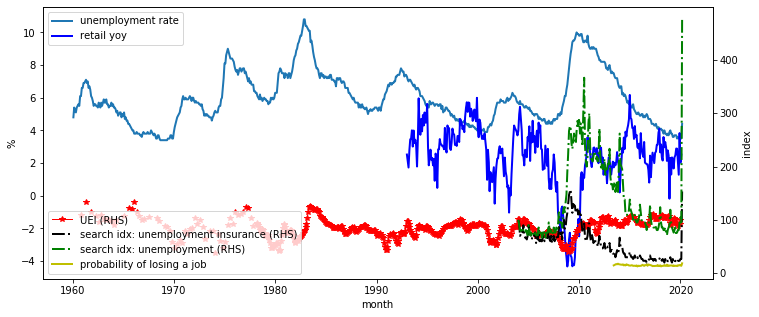

In [53]:
## plot all series 

fig, ax = plt.subplots(figsize = figsize)
ax2 = ax.twinx()
ax.plot(df.index,
        df['ue'],
        lw =2, 
        label = 'unemployment rate')

ax.plot(df.index,
        df['retail_yoy'],
        'b-',
        lw =2, 
        label = 'retail yoy')

ax2.plot(df.index,
         df['ue_exp_idx'],'r*-',
         lw = 1, 
         label = 'UEI (RHS)')
ax2.plot(df.index,
         df['Search: \"unemployment insurance\"'],
         'k-.',
         lw = 2, 
         label = 'search idx: unemployment insurance (RHS)')
ax2.plot(df.index,
         df['Search: \"unemployment\"'],
         'g-.',
         lw = 2, 
         label = 'search idx: unemployment (RHS)')

ax2.plot(df.index,
         df['ue_prob'],
         'y-',
         lw = 2, 
         label = 'probability of losing a job')

#ax2.plot(df.index,df['Search: \"file for unemployment\"'],'g-.',lw = 1, label = 'google search: file for unemployment')
ax.set_xlabel("month",fontsize = fontsize)
ax.set_ylabel('%',fontsize = fontsize)
ax2.set_ylabel('index',fontsize = fontsize)

ax.legend(loc = 0,
          fontsize = fontsize)
ax2.legend(loc = 3,
          fontsize = fontsize)
plt.savefig('figures/working/all')

##  Some trys

Predict change in uemployment rate changes directly using searches 


In [48]:
vars_reg = sub_searches + ['ue_chg']

df_short0 = df[vars_reg].dropna(how ='any')

h  = 1

In [49]:
Y = np.array(df_short0['ue_chg'][h:])
X = np.array(df_short0[sub_searches][:-h])
X = sm.add_constant(X)
model0 = sm.OLS(Y,X)
results0 = model0.fit()
print(results0.summary())

## get results
coefs0 = results0.params
r2_0 = round(results0.rsquared,3)

print('Coefficients of interest:')
print(coefs0)

print('R-squared:')
print(r2_0)


def predict_ue_chg(searches,
                   coefs):
    nb = searches.shape[1]
    print(str(nb)+'searches are used')
    predict_values = coefs[0] 
    n = 1
    while n <= nb:
        predict_values += coefs[n]*searches.T[n-1]
        n = n+1
    return predict_values

## predict the UEI using google trends in/out of sample 

ue_exp_chg_search_prd = predict_ue_chg(np.array(df[sub_searches].dropna(how ='any')),
                                coefs0)
ue_exp_chg_search_prd_index = df[sub_searches].dropna(how ='any').index  # two months in the end are out of sample.

prd_df0 = pd.DataFrame(ue_exp_chg_search_prd,
                      columns = ['ue_exp_chg_search_prd'],
                      index = ue_exp_chg_search_prd_index)
 
## add the predicted uei to the master dataframe 

df = pd.merge(df,
             prd_df0,
             left_index = True,
             right_index = True,
             how = 'outer')

## create another series with historical uei in sample and predicted for out of sample

#df['ue_exp_idx_long']= df['ue_exp_idx']
#df['ue_exp_idx_long'] = df['ue_exp_idx_long'].fillna(df['ue_exp_idx_prd'])

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.631
Model:                            OLS   Adj. R-squared:                  0.623
Method:                 Least Squares   F-statistic:                     80.79
Date:                Mon, 06 Apr 2020   Prob (F-statistic):           7.40e-40
Time:                        16:47:32   Log-Likelihood:                -200.71
No. Observations:                 194   AIC:                             411.4
Df Residuals:                     189   BIC:                             427.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.9450      0.256    -11.526      0.0

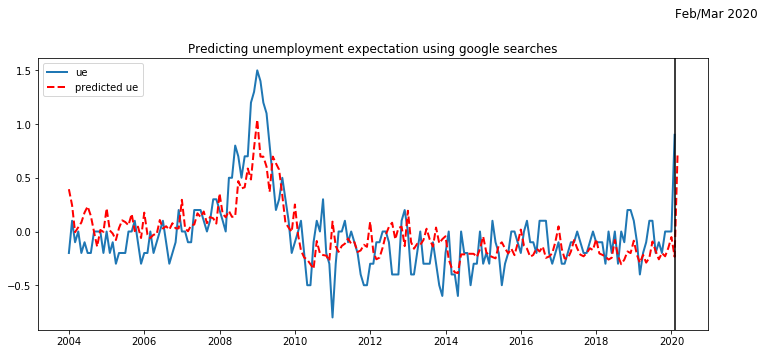

In [146]:
outsample_time =  datetime.datetime(2020,2,1)

fig = plt.figure(figsize = figsize)
plt.plot(ue_exp_chg_search_prd_index[:-h],
         np.array(df['ue_chg'].loc[ue_exp_chg_search_prd_index][h:]),
                  lw = 2, label = 'ue')
plt.plot(ue_exp_chg_search_prd_index,
         ue_exp_chg_search_prd,'r--',lw = 2,label='predicted ue')
plt.axvline(x = outsample_time,
            color = 'black')
plt.text(outsample_time, 2, 'Feb/Mar 2020', fontsize = 12)  # mark the out-of-sample prediction 
plt.legend(loc = 2)
plt.title('Predicting unemployment expectation using google searches')
plt.savefig('figures/working/ue_chg_search_predict')
# Make this an out of sample plot (for the predicted)

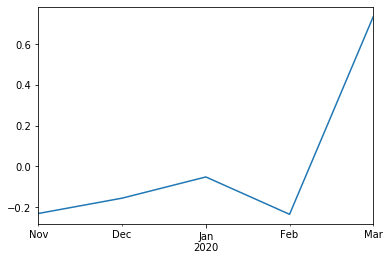

In [147]:
df['ue_exp_chg_search_prd'].tail().plot()

## Regression

### Step 1.  predict michigan index using google search  


\begin{eqnarray}
\underbrace{\texttt{UEI}_{t}}_{\text{Unemployment expectation index}} = \alpha + \sum^2_{k=1}\beta_k \texttt{Search}_{k,t} + \epsilon_{t}
\end{eqnarray}

- $\texttt{UEI}$: unemployment expectation index
- $\texttt{Search}_{k,t}$: google search index for query $k$, e.g. "unemployment insurance", "unemployment office", etc. All indicies are normalized by their initial value at the first period of the sample. 

In [21]:
vars_reg = sub_searches + ['ue_exp_idx']

df_short1 = df[vars_reg].dropna(how ='any')

Y = df_short1[['ue_exp_idx']]
X = df_short1[sub_searches]
X = sm.add_constant(X)
model = sm.OLS(Y,X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:             ue_exp_idx   R-squared:                       0.647
Model:                            OLS   Adj. R-squared:                  0.637
Method:                 Least Squares   F-statistic:                     68.42
Date:                Fri, 03 Apr 2020   Prob (F-statistic):           2.13e-40
Time:                        08:45:27   Log-Likelihood:                -713.72
No. Observations:                 193   AIC:                             1439.
Df Residuals:                     187   BIC:                             1459.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const   

In [22]:
coefs1 = results.params
r2_1 = round(results.rsquared,3)

print('Coefficients of interest:')
print(coefs1)

print('R-squared:')
print(r2_1)

Coefficients of interest:
const                               99.967369
Search: "unemployment insurance"    -0.392594
Search: "unemployment"              -0.015527
Search: "unemployed"                 0.262618
Search: "unemployment office"       -0.113180
Search: "file for unemployment"     -0.018271
dtype: float64
R-squared:
0.647


In [23]:
def predict_ue_exp(searches,
                   coefs):
    nb = searches.shape[1]
    print(str(nb)+'searches are used')
    predict_values = coefs[0] 
    n = 1
    while n <= nb:
        predict_values += coefs[n]*searches.T[n-1]
        n = n+1
    return predict_values

In [24]:
## predict the UEI using google trends in/out of sample 

ue_exp_idx_prd = predict_ue_exp(np.array(df[sub_searches].dropna(how ='any')),
                                coefs1)
ue_exp_idx_prd_index = df[sub_searches].dropna(how ='any').index  # two months in the end are out of sample.

prd_df = pd.DataFrame(ue_exp_idx_prd,
                      columns = ['ue_exp_idx_prd'],
                      index = ue_exp_idx_prd_index)
 
## add the predicted uei to the master dataframe 

df = pd.merge(df,
             prd_df,
             left_index = True,
             right_index = True,
             how = 'outer')

## create another series with historical uei in sample and predicted for out of sample

df['ue_exp_idx_long']= df['ue_exp_idx']
df['ue_exp_idx_long'] = df['ue_exp_idx_long'].fillna(df['ue_exp_idx_prd'])

5searches are used


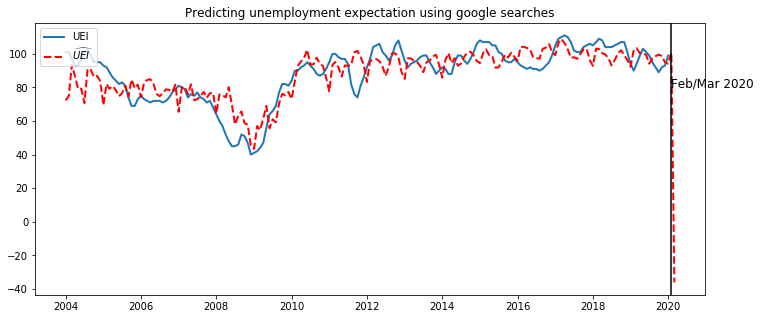

In [25]:
outsample_time =  datetime.datetime(2020,2,1)

fig = plt.figure(figsize = figsize)
plt.plot(df_short1.index,
         df_short1['ue_exp_idx'], lw = 2, label = 'UEI')
plt.plot(ue_exp_idx_prd_index,
         ue_exp_idx_prd,'r--',lw = 2,label=r'$\widehat{UEI}$')
plt.axvline(x = outsample_time,
            color = 'black')
plt.text(outsample_time, 80, 'Feb/Mar 2020', fontsize = 12)  # mark the out-of-sample prediction 
plt.legend(loc = 2)
plt.title('Predicting unemployment expectation using google searches')
plt.savefig('figures/working/ue_exp_idx_predict')
# Make this an out of sample plot (for the predicted)

In [26]:
df.columns

Index(['Search: "unemployment insurance"', 'Search: "unemployment"',
       'Search: "unemployed"', 'Search: "unemployment office"',
       'Search: "file for unemployment"', 'Recession', 'ue_exp_idx', 'ue',
       'retail_yoy', 'ue_exp_idx_prd', 'ue_exp_idx_long'],
      dtype='object')

### Step 2.  predict future realized unemployment rate change using expectations 

\begin{eqnarray}
\texttt{U}_{t+h} - \texttt{U}_{t} & = & a_{0}+ a_{1}\widehat{\texttt{UEI}}_{t} + \eta_{t}
\end{eqnarray}

- $\texttt{U}_{t+h}$: h-month-ahead realized unemployment rate, h = 12 by default. change h to predict for different horizons 
- $\widehat{\texttt{UEI}}_{t}$: predicted unemployment rate expectation index at time $t$ 

\begin{eqnarray}
\widehat{\texttt{U}}_{t+h} &= & \hat{a}_{0}+ \hat{a}_{1}\widehat{\texttt{UEI}}_{t} + \texttt{U}_{t} 
\end{eqnarray}


### Model 1 for step 2: using $\widehat{\texttt{UEI}}$

In [27]:
## ols regression
df_short2 = df[['ue_chg','ue_exp_idx_prd']].dropna(how ='any')

## # of months lag 
############################################################
h = 12  #by default, next month unemployment rate 
#############################################################

Y = np.array(df_short2['ue_chg'][h:])
X = np.array(df_short2['ue_exp_idx_prd'][:-h])
X = sm.add_constant(X)
model2 = sm.OLS(Y,X)
results2 = model2.fit()
print(results2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.384
Model:                            OLS   Adj. R-squared:                  0.380
Method:                 Least Squares   F-statistic:                     112.0
Date:                Fri, 03 Apr 2020   Prob (F-statistic):           1.16e-20
Time:                        08:45:58   Log-Likelihood:                -239.94
No. Observations:                 182   AIC:                             483.9
Df Residuals:                     180   BIC:                             490.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.5599      0.448     10.179      0.0

In [28]:
coefs2 = results2.params
r2_2 = round(results2.rsquared,3)

print('When using predicted UEI')
print('Estimated coefficients:')
print(coefs2)

print('R-squared:')
print(r2_2)

When using predicted UEI
Estimated coefficients:
[ 4.55988836 -0.0534142 ]
R-squared:
0.384


In [29]:
# function that predict change in unemployment rate 

def predict_ue(uei,
               coefs):
    predict_values = coefs[0] + (coefs[1]*uei.T)
    return predict_values

In [30]:
## predict the UE changes using predicted UEI 

ue_chg_prd = predict_ue(np.array(df['ue_exp_idx_prd'].dropna(how ='any')),
                        coefs2)
ue_chg_index = df['ue_exp_idx_prd'].dropna(how ='any').index  # two months in the end are out of sample.

prd_df2 = pd.DataFrame(ue_chg_prd,
                       columns = ['ue_chg_prd'],
                       index = ue_chg_index)
df = pd.merge(df,
              prd_df2,
              left_index = True,
              right_index = True,
              how = 'outer')

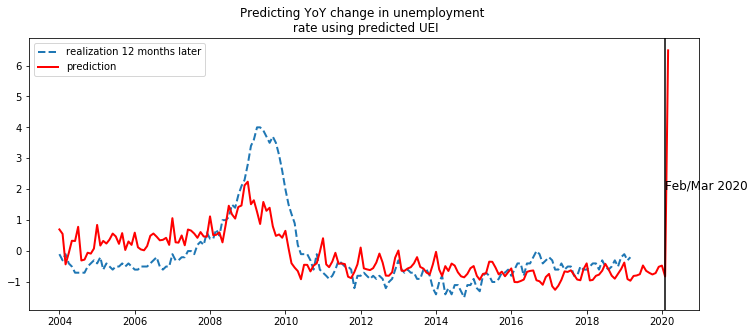

In [31]:
fig = plt.figure(figsize = figsize)

plt.plot(ue_chg_index[:-h],
         np.array(df['ue_chg'].loc[ue_chg_index][:-h]), 
         '--',
         lw = 2, 
         label = 'realization 12 months later')
plt.plot(ue_chg_index,
         ue_chg_prd,
         'r-',
         lw = 2,
         label='prediction')
plt.title('Predicting YoY change in unemployment \n rate using predicted UEI')
plt.axvline(x = outsample_time,
            color = 'black')
plt.text(outsample_time, 2, 'Feb/Mar 2020', fontsize = 12)  # mark the out-of-sample prediction 
plt.legend(loc = 2)
plt.savefig('figures/working/ue_change_predict_predicted_uei')

Notice the in the figure above, the last observation for 12-month-ahead realization of YoY retail sale growth is Jan 2019. 

### Model 2 for step 2: using $\texttt{UEI}$

In [32]:
## ols regression

df['ue_chg'] = df['ue'].diff(periods = 12) ## yoy change of unemployment rate 
df_short3 = df[['ue_chg','ue_exp_idx']].dropna(how ='any')

## # of months lag 
############################################################
h = 12  #by default, next month unemployment rate 
#############################################################

Y = np.array(df_short3['ue_chg'][h:])
X = np.array(df_short3['ue_exp_idx'][:-h])
X = sm.add_constant(X)
model3 = sm.OLS(Y,X)
results3 = model3.fit()
print(results3.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.231
Model:                            OLS   Adj. R-squared:                  0.229
Method:                 Least Squares   F-statistic:                     163.8
Date:                Fri, 03 Apr 2020   Prob (F-statistic):           5.54e-33
Time:                        08:46:12   Log-Likelihood:                -726.37
No. Observations:                 548   AIC:                             1457.
Df Residuals:                     546   BIC:                             1465.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.4038      0.196     12.276      0.0

In [33]:
coefs3 = results3.params
r2_3 = round(results3.rsquared,3)

print('When using realized  UEI')
print('Estimated coefficients:')
print(coefs3)

print('R-squared:')
print(r2_3)

When using realized  UEI
Estimated coefficients:
[ 2.40379316 -0.02910323]
R-squared:
0.231


In [34]:
## predict the UE changes using realized UEI 

ue_chg_prd2 = predict_ue(np.array(df['ue_exp_idx_long'].dropna(how ='any')),
                        coefs3)

ue_chg_index2 = df['ue_exp_idx_long'].dropna(how ='any').index  # two months in the end are out of sample.

prd_df3 = pd.DataFrame(ue_chg_prd2,
                       columns = ['ue_chg_prd2'],
                       index = ue_chg_index2)
df = pd.merge(df,
              prd_df3,
              left_index = True,
              right_index = True,
              how = 'outer')

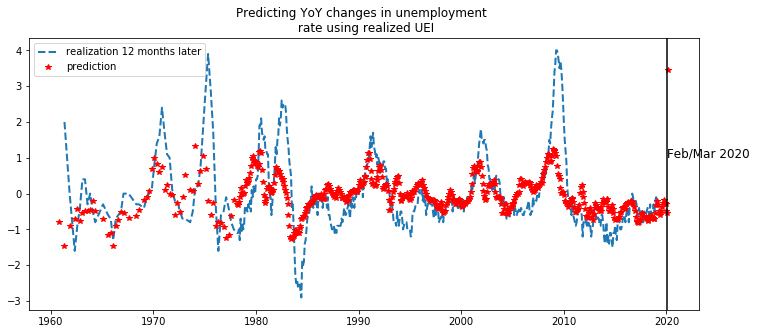

In [35]:
fig = plt.figure(figsize = figsize)
plt.plot(ue_chg_index2[:-h],
         np.array(df['ue_chg'].loc[ue_chg_index2][:-h]),
         '--',
         lw = 2, 
         label = 'realization 12 months later')
plt.plot(ue_chg_index2,
         ue_chg_prd2,
         'r*',
         lw = 2,
         label='prediction')
plt.title('Predicting YoY changes in unemployment \n rate using realized UEI')
plt.axvline(x = outsample_time,
            color = 'black')
plt.text(outsample_time, 1, 'Feb/Mar 2020', fontsize = 12)  # mark the out-of-sample prediction
plt.legend(loc = 2)
plt.savefig('figures/working/ue_change_predict_realized_uei')

## Zoom-in the recent sample 

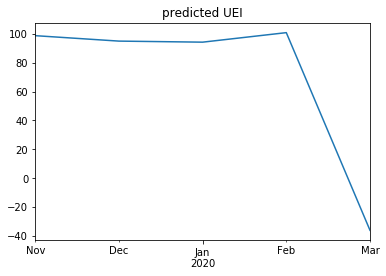

In [36]:
df['ue_exp_idx_prd'].tail().plot(title = 'predicted UEI')
plt.savefig('figures/ue_exp_idx_predict_recent')

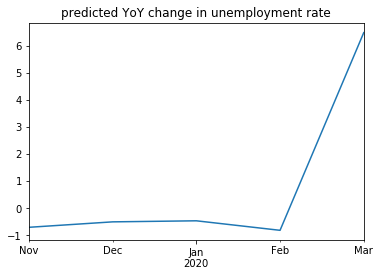

In [37]:
df['ue_chg_prd'].tail().plot(title = 'predicted YoY change in unemployment rate')
plt.savefig('figures/working/ue_change_predict_recent')

## Retail and unemployment expectations 

### Model 0. 

\begin{eqnarray}
\newcommand{\Retail}{\texttt{log RS}}
\Retail_{t+12} - \Retail_{t}  = & \gamma_{0} + \gamma_{1}({U}_{t+12}-{U_{t}}) & \text{Over history to 2019-JAN}
\end{eqnarray}

where 
  - $\texttt{log RS}$ is retail sales excluding vehicles and gas

In [38]:
## retail and unemployment rate changes 

## ols regression
df_short4a = df[['retail_yoy','ue_chg']].dropna(how ='any')

Y = np.array(df_short4a['retail_yoy'])
X = np.array(df_short4a['ue_chg'])
X = sm.add_constant(X)
model4a = sm.OLS(Y,X)
results4a = model4a.fit()
print(results4a.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.501
Model:                            OLS   Adj. R-squared:                  0.500
Method:                 Least Squares   F-statistic:                     325.5
Date:                Fri, 03 Apr 2020   Prob (F-statistic):           7.34e-51
Time:                        08:47:21   Log-Likelihood:                -569.48
No. Observations:                 326   AIC:                             1143.
Df Residuals:                     324   BIC:                             1151.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.1886      0.078     28.065      0.0

In [39]:
coefs4a = results4a.params
r2_4a = round(results4a.rsquared,3)

print('When using realized  UEI')
print('Estimated coefficients:')
print(coefs4a)

print('R-squared:')
print(r2_4a)

When using realized  UEI
Estimated coefficients:
[ 2.18856615 -1.46219231]
R-squared:
0.501


In [40]:
def predict_rs_yoy(ue_or_exp,
                  coefs):
    predict_values = coefs[0] + (coefs[1]*ue_or_exp.T)
    return predict_values

In [41]:
## predict the rs changes using change in UE

rs_yoy_ue_prd_a = predict_rs_yoy(np.array(df['ue_chg'].dropna(how ='any')),
                               coefs4a)
rs_yoy_index_a = df['ue_chg'].dropna(how ='any').index  # two months in the end are out of sample.

prd_df4a = pd.DataFrame(rs_yoy_ue_prd_a,
                       columns = ['rs_yoy_ue_prd_a'],
                       index = rs_yoy_index_a)
df = pd.merge(df,
              prd_df4a,
              left_index = True,
              right_index = True,
              how = 'outer')

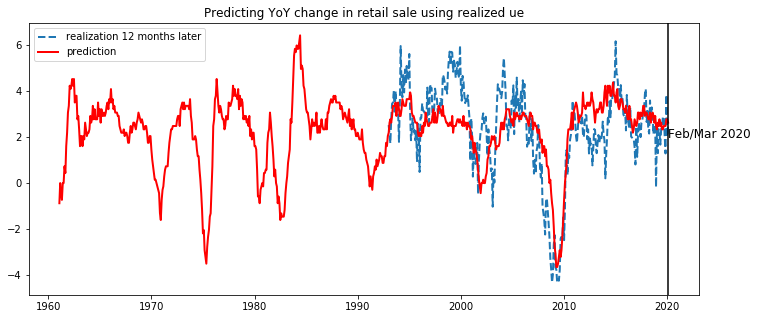

In [42]:
fig = plt.figure(figsize = figsize)
plt.plot(rs_yoy_index_a,
         np.array(df['retail_yoy'].loc[rs_yoy_index_a]),
         '--',
         lw = 2, 
         label = 'realization 12 months later')
plt.plot(rs_yoy_index_a,
         rs_yoy_ue_prd_a,
         'r-',
         lw = 2,
         label='prediction')
plt.title('Predicting YoY change in retail sale using realized ue')
plt.axvline(x = outsample_time,
            color = 'black')
plt.text(outsample_time, 2, 'Feb/Mar 2020', fontsize = 12)  # mark the out-of-sample prediction
plt.legend(loc = 2)
plt.savefig('figures/working/rs_yoy_predict_predicted_ue')

### Model 1. 

\begin{eqnarray}
\newcommand{\Retail}{\texttt{log RS}}
\Retail_{t+12} - \Retail_{t}  = & \gamma_{0} + \gamma_{1} \hat{U}_{t+12} & \text{Over history to 2019-JAN}
\end{eqnarray}

where 
  - $\texttt{log RS}$ is retail sales excluding vehicles and gas

In [43]:
## retail and unemployment rate changes 
#df['ue_prd'] = df['ue']+df['ue_chg_prd']

## ols regression
df_short4 = df[['retail_yoy','ue_chg_prd']].dropna(how ='any')

Y = np.array(df_short4['retail_yoy'][h:])
X = np.array(df_short4['ue_chg_prd'][:-h])
X = sm.add_constant(X)
model4 = sm.OLS(Y,X)
results4 = model4.fit()
print(results4.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.287
Model:                            OLS   Adj. R-squared:                  0.283
Method:                 Least Squares   F-statistic:                     72.57
Date:                Fri, 03 Apr 2020   Prob (F-statistic):           6.31e-15
Time:                        08:47:22   Log-Likelihood:                -362.86
No. Observations:                 182   AIC:                             729.7
Df Residuals:                     180   BIC:                             736.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.5562      0.135     11.568      0.0

In [44]:
coefs4 = results4.params
r2_4 = round(results4.rsquared,3)

print('When using realized  UEI')
print('Estimated coefficients:')
print(coefs4)

print('R-squared:')
print(r2_4)

When using realized  UEI
Estimated coefficients:
[ 1.55622982 -1.58140167]
R-squared:
0.287


In [45]:
## predict the rs changes using change in UE

rs_yoy_ue_prd = predict_rs_yoy(np.array(df['ue_chg_prd'].dropna(how ='any')),
                               coefs4)
rs_yoy_index = df['ue_chg_prd'].dropna(how ='any').index  # two months in the end are out of sample.

prd_df4 = pd.DataFrame(rs_yoy_ue_prd,
                       columns = ['rs_yoy_ue_prd'],
                       index = rs_yoy_index)
df = pd.merge(df,
              prd_df4,
              left_index = True,
              right_index = True,
              how = 'outer')

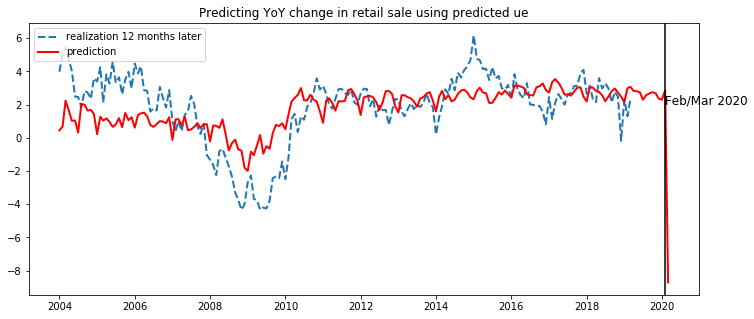

In [46]:
fig = plt.figure(figsize = figsize)
plt.plot(rs_yoy_index[:-h],
         np.array(df['retail_yoy'].loc[rs_yoy_index][:-h]),
         '--',
         lw = 2, 
         label = 'realization 12 months later')
plt.plot(rs_yoy_index,
         rs_yoy_ue_prd,
         'r-',
         lw = 2,
         label='prediction')
plt.title('Predicting YoY change in retail sale using predicted ue')
plt.axvline(x = outsample_time,
            color = 'black')
plt.text(outsample_time, 2, 'Feb/Mar 2020', fontsize = 12)  # mark the out-of-sample prediction
plt.legend(loc = 2)
plt.savefig('figures/working/rs_yoy_predict_predicted_ue')

Notice in the figure above, both series end in January 2020, the last observation of the available retail sale and unemployment rate data. 

### Model x 

In [47]:
## predict the rs changes using expected change in UE reflected by UEI 

rs_yoy_ue_prd_x = predict_rs_yoy(np.array(df['ue_chg_prd2'].dropna(how ='any')),
                                 coefs4)
rs_yoy_index_x = df['ue_chg_prd2'].dropna(how ='any').index  # two months in the end are out of sample.

prd_df4_x = pd.DataFrame(rs_yoy_ue_prd,
                       columns = ['rs_yoy_ue_prd_x'],
                       index = rs_yoy_index)
df = pd.merge(df,
              prd_df4_x,
              left_index = True,
              right_index = True,
              how = 'outer')

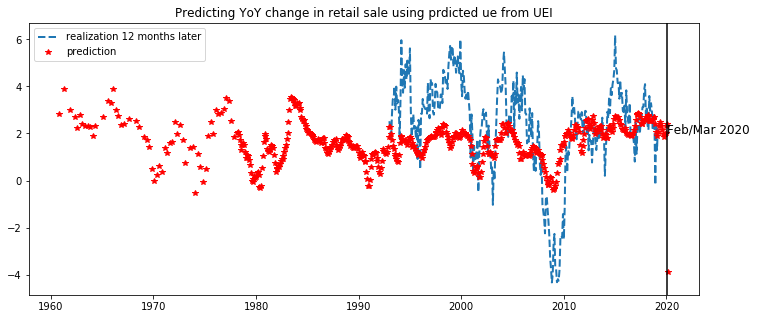

In [48]:
fig = plt.figure(figsize = figsize)

plt.plot(rs_yoy_index_x[:-h],
         np.array(df['retail_yoy'].loc[rs_yoy_index_x][:-h]),
         '--',
         lw = 2, 
         label = 'realization 12 months later')
plt.plot(rs_yoy_index_x,
         rs_yoy_ue_prd_x,
         'r*',
         lw = 2,
         label='prediction')
plt.title('Predicting YoY change in retail sale using prdicted ue from UEI')
plt.axvline(x = outsample_time,
            color = 'black')
plt.text(outsample_time, 2, 'Feb/Mar 2020', fontsize = 12)  # mark the out-of-sample prediction
plt.legend(loc = 2)
plt.savefig('figures/working/rs_yoy_predict_predicted2_ue')

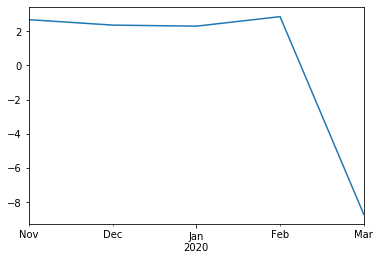

In [49]:
df['rs_yoy_ue_prd_x'].tail().plot()

### Model 2


\begin{eqnarray}
\newcommand{\Retail}{\texttt{log RS}}
\Retail_{t+12} - \Retail_{t}  = & \gamma_{0} + \gamma_{1} \texttt{UEI}_{t} & \text{Over history to 2019-JAN}
\end{eqnarray}



In [50]:
## retail and unemployment and UEI  


## ols regression
df_short5 = df[['retail_yoy','ue_exp_idx']].dropna(how ='any')

## # of months lag 
############################################################
h = 12  #by default, next month unemployment rate 
#############################################################

Y = np.array(df_short5['retail_yoy'][h:])
X = np.array(df_short5['ue_exp_idx'][:-h])
X = sm.add_constant(X)
model5 = sm.OLS(Y,X)
results5 = model5.fit()
print(results5.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.191
Model:                            OLS   Adj. R-squared:                  0.188
Method:                 Least Squares   F-statistic:                     73.32
Date:                Fri, 03 Apr 2020   Prob (F-statistic):           5.17e-16
Time:                        08:47:35   Log-Likelihood:                -627.49
No. Observations:                 313   AIC:                             1259.
Df Residuals:                     311   BIC:                             1266.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.6406      0.594     -4.444      0.0

In [51]:
coefs5 = results5.params
r2_5 = round(results4.rsquared,3)

print('When using realized  UEI')
print('Estimated coefficients:')
print(coefs5)

print('R-squared:')
print(r2_5)

When using realized  UEI
Estimated coefficients:
[-2.64060501  0.05860244]
R-squared:
0.287


In [52]:
## predict the UE changes using realized UEI 

rs_yoy_uei_prd = predict_rs_yoy(np.array(df['ue_exp_idx_long'].dropna(how ='any')),
                                coefs5)
rs_yoy_index2 = df['ue_exp_idx_long'].dropna(how ='any').index  # two months in the end are out of sample.

prd_df5 = pd.DataFrame(rs_yoy_uei_prd,
                       columns = ['rs_yoy_uei_prd'],
                       index = rs_yoy_index2)
df = pd.merge(df,
              prd_df5,
              left_index = True,
              right_index = True,
              how = 'outer')

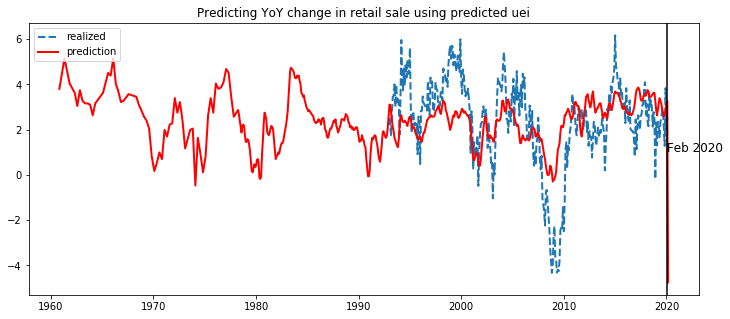

In [53]:
fig = plt.figure(figsize = figsize)
plt.plot(rs_yoy_index2,
         np.array(df['retail_yoy'].loc[rs_yoy_index2]),
         '--',
         lw = 2, 
         label = 'realized')
plt.plot(rs_yoy_index2,
         rs_yoy_uei_prd,
         'r-',
         lw = 2,
         label='prediction')
plt.title('Predicting YoY change in retail sale using predicted uei')
plt.axvline(x = outsample_time,
            color = 'black',)
plt.text(outsample_time, 1, 'Feb 2020', fontsize = 12)  # mark the out-of-sample prediction 
plt.legend(loc = 2)
plt.savefig('figures/working/rs_yoy_predict_predicted_uei')

Notice in the figure above, both series end in January 2020, the last observation of the available retail sale and unemployment rate data. 

Since the interpolated UEI goes back to 1960s, the forecast of unemployment rate for the same period is available.

### Model 4

\begin{eqnarray}
\newcommand{\Retail}{\texttt{log RS}}
\Retail_{t+12} - \Retail_{t}  = & \gamma_{0} + \gamma_{1} \widehat{\texttt{UEI}}_{t}  &\text{Using measured UEI data through its end, then forecasted UEI for last couple of months}
\end{eqnarray}

In [54]:
## retail and unemployment and predicted UEI  

## ols regression
df_short6 = df[['retail_yoy','ue_exp_idx_prd']].dropna(how ='any')

Y = np.array(df_short6['retail_yoy'][h:])
X = np.array(df_short6['ue_exp_idx_prd'][:-h])
X = sm.add_constant(X)
model6 = sm.OLS(Y,X)
results6 = model6.fit()
print(results6.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.287
Model:                            OLS   Adj. R-squared:                  0.283
Method:                 Least Squares   F-statistic:                     72.57
Date:                Fri, 03 Apr 2020   Prob (F-statistic):           6.31e-15
Time:                        08:47:42   Log-Likelihood:                -362.86
No. Observations:                 182   AIC:                             729.7
Df Residuals:                     180   BIC:                             736.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -5.6548      0.880     -6.424      0.0

In [55]:
coefs6 = results6.params
r2_6 = round(results6.rsquared,3)

print('When using realized  UEI')
print('Estimated coefficients:')
print(coefs6)

print('R-squared:')
print(r2_6)

When using realized  UEI
Estimated coefficients:
[-5.65478524  0.08446931]
R-squared:
0.287


In [56]:
## predict the UE changes using realized UEI 

rs_yoy_hat_uei_prd = predict_rs_yoy(np.array(df['ue_exp_idx_prd'].dropna(how ='any')),
                                    coefs6)
rs_yoy_index3 = df['ue_exp_idx_prd'].dropna(how ='any').index  # two months in the end are out of sample.

prd_df6 = pd.DataFrame(rs_yoy_hat_uei_prd,
                       columns = ['rs_yoy_hat_uei_prd'],
                       index = rs_yoy_index3)
df = pd.merge(df,
              prd_df6,
              left_index = True,
              right_index = True,
              how = 'outer')

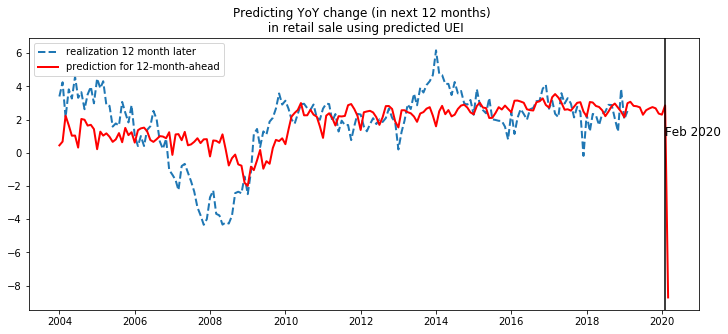

In [57]:
fig = plt.figure(figsize = figsize)
plt.plot(rs_yoy_index3[:-h],
         np.array(df['retail_yoy'].loc[rs_yoy_index3][h:]),  # trucate h  
         '--',
         lw = 2, 
         label = 'realization 12 month later')
plt.plot(rs_yoy_index3,
         rs_yoy_hat_uei_prd,
         'r-',
         lw = 2,
         label='prediction for 12-month-ahead')
plt.title('Predicting YoY change (in next 12 months) \n in retail sale using predicted UEI')
plt.axvline(x = outsample_time,
            color = 'black')
plt.text(outsample_time, 1, 'Feb 2020', fontsize = 12)  # mark the out-of-sample prediction 

plt.legend(loc = 2)
plt.savefig('figures/working/rs_yoy_predict_realized_uei')

Notice the in the figure above, the last observation for 12-month-ahead realization of YoY retail sale growth is Jan 2019. 

### Zoom-in 

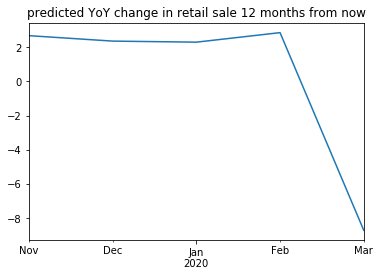

In [58]:
df['rs_yoy_hat_uei_prd'].tail().plot(title = 'predicted YoY change in retail sale 12 months from now')
plt.savefig('figures/working/rs_yoy_predict_recent')